In [1]:
!pip install pymongo pandas matplotlib


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Step 1: Import libraries
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 2: Load data
df = pd.read_csv("covid data set.csv")

In [4]:
df.head()

,location,date,new_cases,total_deaths,population
0,USA,1/1/2021,10000,500000,331000000
1,India,1/2/2021,9000,400000,1380000000
2,Brazil,1/3/2021,8000,300000,212000000
3,Russia,1/4/2021,7000,200000,146000000
4,UK,1/5/2021,6000,100000,67800000


In [5]:
print('Shape of dataset: ', df.shape)

Shape of dataset:  (12500, 5)


In [6]:
df.columns

Index(['location', 'date', 'new_cases', 'total_deaths', 'population'], dtype='object')

In [7]:
#Summary of the datatset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      12500 non-null  object
 1   date          12500 non-null  object
 2   new_cases     12500 non-null  int64 
 3   total_deaths  12500 non-null  int64 
 4   population    12500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 488.4+ KB


In [8]:
#Provides metadata information
df.describe()

,new_cases,total_deaths,population
count,12500.000000,12500.000000,1.250000e+04
mean,8000.000000,300000.000000,4.273600e+08
std,1414.270134,141427.013431,4.840927e+08
min,6000.000000,100000.000000,6.780000e+07
25%,7000.000000,200000.000000,1.460000e+08
50%,8000.000000,300000.000000,2.120000e+08
75%,9000.000000,400000.000000,3.310000e+08
max,10000.000000,500000.000000,1.380000e+09


In [9]:
# Calculating the total number of missing values in each column of the dataset
df.isnull().sum()

location        0
date            0
new_cases       0
total_deaths    0
population      0
dtype: int64

In [10]:
#Checking if duplicate values are present
duplicate_values = df.duplicated().sum()
duplicate_values

np.int64(10000)

In [11]:
#Dropping duplicate values
drop_duplicate_values = df.drop_duplicates()
drop_duplicate_values

,location,date,new_cases,total_deaths,population
0,USA,1/1/2021,10000,500000,331000000
1,India,1/2/2021,9000,400000,1380000000
2,Brazil,1/3/2021,8000,300000,212000000
3,Russia,1/4/2021,7000,200000,146000000
4,UK,1/5/2021,6000,100000,67800000
...,...,...,...,...,...
2495,USA,11/1/2027,10000,500000,331000000
2496,India,11/2/2027,9000,400000,1380000000
2497,Brazil,11/3/2027,8000,300000,212000000
2498,Russia,11/4/2027,7000,200000,146000000


In [12]:
drop_duplicate_values.to_csv("cleaned_data.csv", index=False)

In [13]:
drop_duplicate_values.shape

(2500, 5)

In [14]:
print("File saved successfully")

File saved successfully


In [15]:
from pymongo import MongoClient
import pandas as pd

# Read CSV and clean duplicates
df = pd.read_csv("covid data set.csv")
drop_duplicate_values = df.drop_duplicates()
drop_duplicate_values.to_csv("cleaned_data.csv", index=False)

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['covid_db']
collection = db['Covide_stats']

# Drop existing data
collection.drop()

# Insert cleaned data
collection.insert_many(drop_duplicate_values.to_dict(orient='records'))

# Confirm insert
print("Rows inserted into MongoDB:", collection.count_documents({}))


Rows inserted into MongoDB: 2500


In [16]:
pipeline = [
    {"$group": {
        "_id": "$location",
        "avg_new_cases": {"$avg": "$new_cases"}
    }},
    {"$sort": {"avg_new_cases": -1}}
]

results = list(collection.aggregate(pipeline))

# Show top 5 results
results[:5]

[{'_id': 'USA', 'avg_new_cases': 10000.0},
 {'_id': 'India', 'avg_new_cases': 9000.0},
 {'_id': 'Brazil', 'avg_new_cases': 8000.0},
 {'_id': 'Russia', 'avg_new_cases': 7000.0},
 {'_id': 'UK', 'avg_new_cases': 6000.0}]

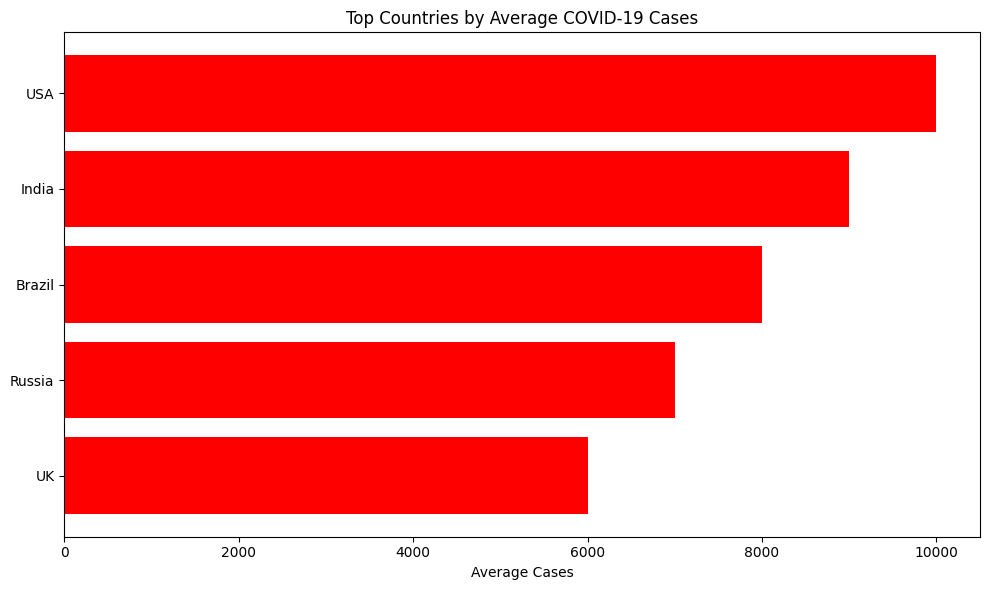

In [17]:
# Get the top countries
top_countries = results[:10]

# Extract country names and average cases
countries = [entry['_id'] for entry in top_countries]
avg_cases = [entry['avg_new_cases'] for entry in top_countries]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(countries, avg_cases, color='Red')
plt.xlabel("Average Cases")
plt.title("Top Countries by Average COVID-19 Cases")
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

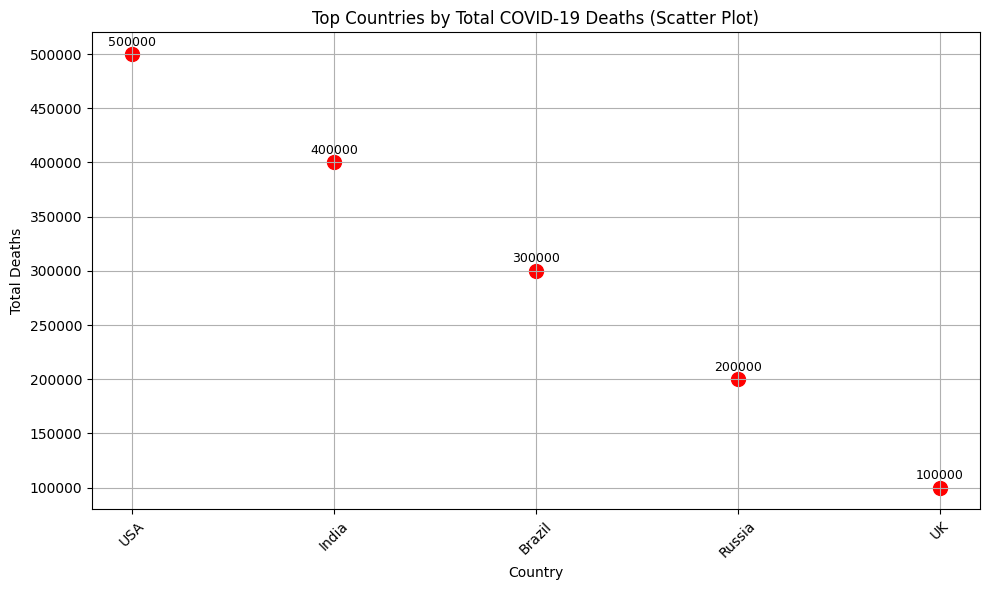

In [23]:


# Get the latest total deaths for each country
latest_deaths = df.sort_values('date').groupby('location').last()['total_deaths']

# Top 5 countries (depending on your dataset)
top_deaths = latest_deaths.sort_values(ascending=False).head(10)

# Prepare data
countries = top_deaths.index
deaths = top_deaths.values

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(countries, deaths, color='red', s=100)  # s = marker size
plt.title("Top Countries by Total COVID-19 Deaths (Scatter Plot)")
plt.xlabel("Country")
plt.ylabel("Total Deaths")
plt.xticks(rotation=45)

# Add value labels above each point
for i in range(len(countries)):
    plt.text(countries[i], deaths[i] + max(deaths) * 0.01, f'{int(deaths[i])}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(True)
plt.show()



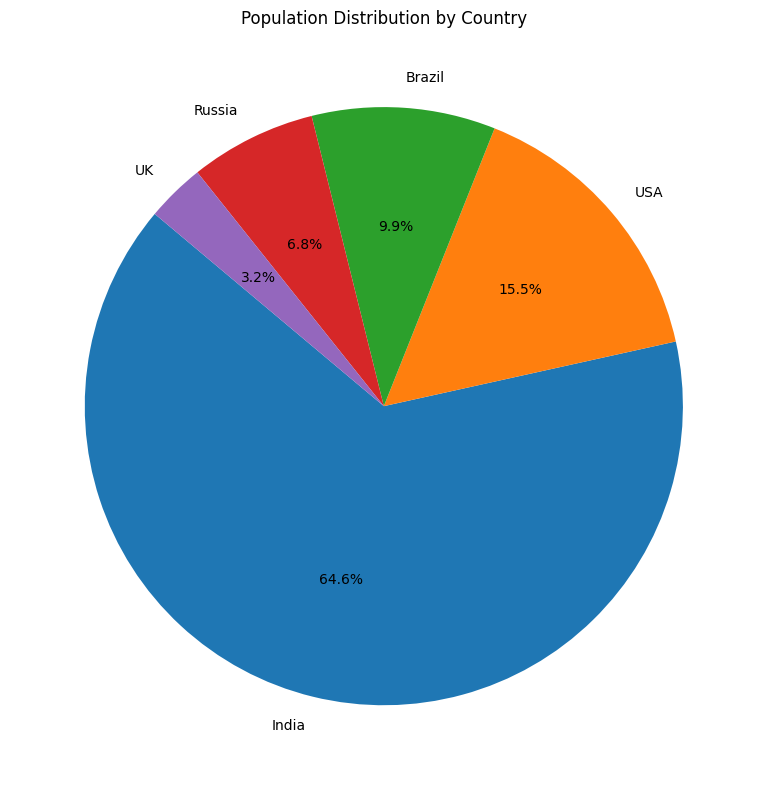

In [22]:
# Get the latest data per country
latest_population = df.sort_values('date').groupby('location').last()

# Get population data sorted
population_data = latest_population['population'].sort_values(ascending=False)

# Plot as pie chart
plt.figure(figsize=(8, 8))
plt.pie(population_data, labels=population_data.index, autopct='%1.1f%%', startangle=140)
plt.title("Population Distribution by Country")
plt.tight_layout()
plt.show()


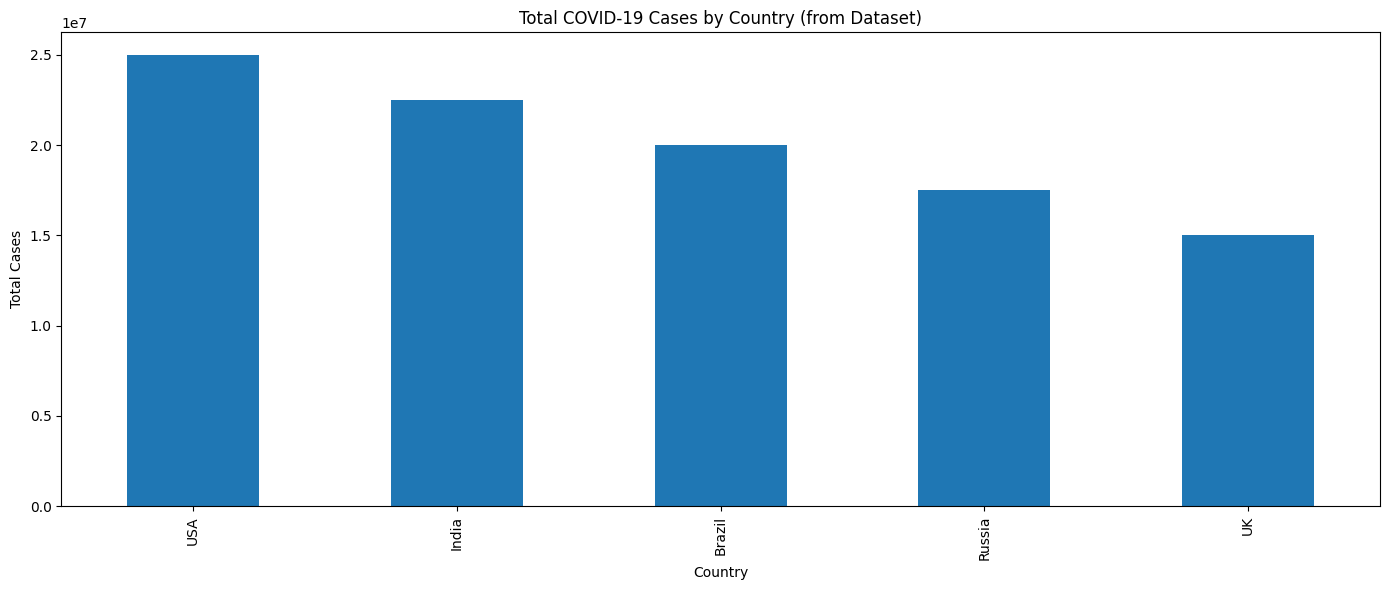

In [21]:
# Sum total new cases per country
total_cases = df.groupby('location')['new_cases'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
total_cases.plot(kind='bar')
plt.title("Total COVID-19 Cases by Country (from Dataset)")
plt.xlabel("Country")
plt.ylabel("Total Cases")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
